In [75]:
import sympy as sp
from sympy import symbols, Matrix, cos, sin, simplify, expand, collect, pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.backends.backend_pdf import PdfPages
import time
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp

from mpl_toolkits import mplot3d

%matplotlib notebook

# Define the variables
t, r, theta, phi, a, Lambda, J = symbols('t r theta phi a Lambda, J')
dt, dr, dtheta, dphi, M = symbols('dt dr dtheta dphi M')

a = J/M

Delta = r**2 - 2*M*r + a**2

Sigma = r**2 + a**2 * cos(theta)**2
# Equations of motion in sympy, most other in numpy

In [76]:
# Metric Elements (Kerr)
gtt = -(1 - (2*M*r)/(Sigma))
grr = Sigma/Delta
gthetatheta = Sigma
gphiphi = (r**2 + a**2 + (2*a**2 * M * r * sin(theta)**2)/Sigma)*sin(theta)**2

gtphi = -(4*a*M*r*sin(theta)**2)/Sigma

g = simplify(Matrix([[gtt, 0, 0, gtphi], [0, grr, 0, 0], [0, 0, gthetatheta, 0], [gtphi, 0, 0, gphiphi]]))
g

Matrix([
[                2*M*r/(J**2*cos(theta)**2/M**2 + r**2) - 1,                                                           0,                              0,                                     -4*J*M**2*r*sin(theta)**2/(J**2*cos(theta)**2 + M**2*r**2)],
[                                                         0, (J**2*cos(theta)**2 + M**2*r**2)/(J**2 + M**2*r*(-2*M + r)),                              0,                                                                                              0],
[                                                         0,                                                           0, J**2*cos(theta)**2/M**2 + r**2,                                                                                              0],
[-4*J*M**2*r*sin(theta)**2/(J**2*cos(theta)**2 + M**2*r**2),                                                           0,                              0, (2*J**2*r*sin(theta)**2/(M*(J**2*cos(theta)**2/M**2 + r**2)) + J**2/M**2 + r**2)*sin

In [77]:
ginv = g.inv()
ginv

Matrix([
[(-J**6*cos(theta)**4 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - J**4*M**2*r**2*cos(theta)**4 - 2*J**4*M**2*r**2*cos(theta)**2 - 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**4*r**4*cos(theta)**2 - J**2*M**4*r**4 - M**6*r**6)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6),                                                              0,                                     0,                                                                                                                                                                                                                 (-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*co

In [78]:
pt, pr, ptheta, pphi, m = symbols('pt pr ptheta pphi m')

# Compute the expression for H
Hamil = (1/(2*m)) * (
    ginv[0, 0]* (pt**2) + 
    ginv[1, 1]* (pr**2) + 
    ginv[2, 2]* (ptheta**2) + 
    ginv[3, 3]* (pphi**2) + 
    2*ginv[0, 3]* pt * pphi
)

print(simplify(Hamil))
Hamil

(M**2*pphi**2*(J**2*cos(theta)**2 + M**2*r**2)**2*(J**2*cos(theta)**2 - 2*M**3*r + M**2*r**2) + pt*(-J**2*sin(theta)**2 + J**2 + M**2*r**2)**2*(J**4*pt*sin(theta)**2 - J**4*pt - 2*J**2*M**3*pt*r*sin(theta)**2 + J**2*M**2*pt*r**2*sin(theta)**2 - 2*J**2*M**2*pt*r**2 - 8*J*M**4*pphi*r - M**4*pt*r**4)*sin(theta)**2 + (M**2*ptheta**2 + pr**2*(J**2 - 2*M**3*r + M**2*r**2))*(J**6*cos(theta)**4 + J**4*M**3*r*(1 - cos(4*theta))/4 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6)*sin(theta)**2)/(2*m*(J**2*cos(theta)**2 + M**2*r**2)*(J**6*cos(theta)**4 + J**4*M**3*r*(1 - cos(4*theta))/4 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r*

(M**2*ptheta**2/(J**2*cos(theta)**2 + M**2*r**2) + pphi**2*(J**4*M**2*cos(theta)**4 - 2*J**2*M**5*r*cos(theta)**2 + 2*J**2*M**4*r**2*cos(theta)**2 - 2*M**7*r**3 + M**6*r**4)/(J**6*sin(theta)**2*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**4*cos(theta)**2 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 + J**4*M**2*r**2*sin(theta)**2*cos(theta)**4 + 2*J**4*M**2*r**2*sin(theta)**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**4 + 2*J**2*M**5*r**3*sin(theta)**4 - 2*J**2*M**5*r**3*sin(theta)**2*cos(theta)**2 - 2*J**2*M**5*r**3*sin(theta)**2 + 2*J**2*M**4*r**4*sin(theta)**2*cos(theta)**2 + J**2*M**4*r**4*sin(theta)**2 - 2*M**7*r**5*sin(theta)**2 + M**6*r**6*sin(theta)**2) + 2*pphi*pt*(-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r

In [79]:
from sympy import diff

# Partial derivatives with respect to pt, pr, p_theta, p_phi,
partial_t = diff(Hamil, t)
partial_pt = diff(Hamil, pt)
partial_r = diff(Hamil, r)
partial_pr = diff(Hamil, pr)
partial_theta = diff(Hamil, theta)
partial_p_theta = diff(Hamil, ptheta)
partial_phi = diff(Hamil, phi)
partial_p_phi = diff(Hamil, pphi)

# Partial H partial t is = dpt/dtau, negative inverses (normal hamiltonian mechanics)
print("dpt/dtau:", -partial_t)
print(" ")
print("dt/dtau:", partial_pt)
print(" ")
print("dpr/dtau:", -partial_r)
print(" ")
print("dr/dtau:", partial_pr)
print(" ")
print("dptheta/dtau:", -partial_theta)
print(" ")
print("dtheta/dtau:", partial_p_theta)
print(" ")
print("dpphi/dtau:", -partial_phi)
print(" ")
print("dphi/dtau:", partial_p_phi)

dpt/dtau: 0
 
dt/dtau: (2*pphi*(-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6) + 2*pt*(-J**6*cos(theta)**4 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - J**4*M**2*r**2*cos(theta)**4 - 2*J**4*M**2*r**2*cos(theta)**2 - 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**4*r**4*cos(theta)**2 - J**2*M**4*r**4 - M**6*r**6)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*

 
dpphi/dtau: 0
 
dphi/dtau: (2*pphi*(J**4*M**2*cos(theta)**4 - 2*J**2*M**5*r*cos(theta)**2 + 2*J**2*M**4*r**2*cos(theta)**2 - 2*M**7*r**3 + M**6*r**4)/(J**6*sin(theta)**2*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**4*cos(theta)**2 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 + J**4*M**2*r**2*sin(theta)**2*cos(theta)**4 + 2*J**4*M**2*r**2*sin(theta)**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**4 + 2*J**2*M**5*r**3*sin(theta)**4 - 2*J**2*M**5*r**3*sin(theta)**2*cos(theta)**2 - 2*J**2*M**5*r**3*sin(theta)**2 + 2*J**2*M**4*r**4*sin(theta)**2*cos(theta)**2 + J**2*M**4*r**4*sin(theta)**2 - 2*M**7*r**5*sin(theta)**2 + M**6*r**6*sin(theta)**2) + 2*pt*(-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(

In [83]:
# Set up the parameters
M = 10000 # Mass of the central black hole 
m = 1 # Mass of the planet 
G = 1 # Gravitational Constant 
c = 1 # Speed of light

#J = 0
J = 9.0e7 #Rotational angular momentum of central black hole
#J=9000

#R = 100000000 #Circular orbit
#L = 1000000 #Circular orbit

#R = 100000000 #Elliptical orbit
#L = 900000 #Elliptical orbit

#R = 100000000 #More Elliptical orbit
#L = 250000 #More Elliptical orbit

#R = 900000 #test Elliptical orbit
#L = 54000 #test Elliptical orbit

#R = 700000 #Whirl-zoom
#L = 39000 #Whirl-zoom

#R = 900000 #Crazy
#L = 10000 

R = 500000 #Plunging
L = 5000 

In [84]:
def system_of_odes(t,y):
    r, pr, time, pt, theta, ptheta, phi = y
       
    
    dRdt = (pr*(J**2 - 2*M**3*r + M**2*r**2)/(m*(J**2*cos(theta)**2 + M**2*r**2)))
    
    dpRdt = ( -(-2*M**4*ptheta**2*r/(J**2*cos(theta)**2 + M**2*r**2)**2 - 2*M**2*pr**2*r*(J**2 - 2*M**3*r + M**2*r**2)/(J**2*cos(theta)**2 \
            + M**2*r**2)**2 + L**2*(-2*J**2*M**5*cos(theta)**2 + 4*J**2*M**4*r*cos(theta)**2 - 6*M**7*r**2 + 4*M**6*r**3)/(J**6*sin(theta)**2*cos(theta)**4 \
            + 2*J**4*M**3*r*sin(theta)**4*cos(theta)**2 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 + J**4*M**2*r**2*sin(theta)**2*cos(theta)**4 \
            + 2*J**4*M**2*r**2*sin(theta)**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**4 + 2*J**2*M**5*r**3*sin(theta)**4 \
            - 2*J**2*M**5*r**3*sin(theta)**2*cos(theta)**2 - 2*J**2*M**5*r**3*sin(theta)**2 + 2*J**2*M**4*r**4*sin(theta)**2*cos(theta)**2 \
            + J**2*M**4*r**4*sin(theta)**2 - 2*M**7*r**5*sin(theta)**2 + M**6*r**6*sin(theta)**2) + L**2*(J**4*M**2*cos(theta)**4 \
            - 2*J**2*M**5*r*cos(theta)**2 + 2*J**2*M**4*r**2*cos(theta)**2 - 2*M**7*r**3 + M**6*r**4)*(-2*J**4*M**3*sin(theta)**4*cos(theta)**2 \
            + 2*J**4*M**3*sin(theta)**2*cos(theta)**2 - 2*J**4*M**2*r*sin(theta)**2*cos(theta)**4 - 4*J**4*M**2*r*sin(theta)**2*cos(theta)**2 \
            - 24*J**2*M**6*r*sin(theta)**4 - 6*J**2*M**5*r**2*sin(theta)**4 + 6*J**2*M**5*r**2*sin(theta)**2*cos(theta)**2 \
            + 6*J**2*M**5*r**2*sin(theta)**2 - 8*J**2*M**4*r**3*sin(theta)**2*cos(theta)**2 - 4*J**2*M**4*r**3*sin(theta)**2 \
            + 10*M**7*r**4*sin(theta)**2 - 6*M**6*r**5*sin(theta)**2)/(J**6*sin(theta)**2*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**4*cos(theta)**2 \
            - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 + J**4*M**2*r**2*sin(theta)**2*cos(theta)**4 + 2*J**4*M**2*r**2*sin(theta)**2*cos(theta)**2 \
            + 12*J**2*M**6*r**2*sin(theta)**4 + 2*J**2*M**5*r**3*sin(theta)**4 - 2*J**2*M**5*r**3*sin(theta)**2*cos(theta)**2 \
            - 2*J**2*M**5*r**3*sin(theta)**2 + 2*J**2*M**4*r**4*sin(theta)**2*cos(theta)**2 + J**2*M**4*r**4*sin(theta)**2 - 2*M**7*r**5*sin(theta)**2 \
            + M**6*r**6*sin(theta)**2)**2 + 2*L*pt*(-4*J**3*M**4*cos(theta)**2 - 12*J*M**6*r**2)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 \
            - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 \
            + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 \
            - 2*M**7*r**5 + M**6*r**6) + 2*L*pt*(-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)*(-2*J**4*M**3*sin(theta)**2*cos(theta)**2 \
            + 2*J**4*M**3*cos(theta)**2 - 2*J**4*M**2*r*cos(theta)**4 - 4*J**4*M**2*r*cos(theta)**2 - 24*J**2*M**6*r*sin(theta)**2 \
            - 6*J**2*M**5*r**2*sin(theta)**2 + 6*J**2*M**5*r**2*cos(theta)**2 + 6*J**2*M**5*r**2 - 8*J**2*M**4*r**3*cos(theta)**2 \
            - 4*J**2*M**4*r**3 + 10*M**7*r**4 - 6*M**6*r**5)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 \
            - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 \
            + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 \
            + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6)**2 + pr**2*(-2*M**3 + 2*M**2*r)/(J**2*cos(theta)**2 + M**2*r**2) \
            + pt**2*(-2*J**4*M**3*sin(theta)**2*cos(theta)**2 - 2*J**4*M**2*r*cos(theta)**4 - 4*J**4*M**2*r*cos(theta)**2 \
            - 6*J**2*M**5*r**2*sin(theta)**2 - 8*J**2*M**4*r**3*cos(theta)**2 - 4*J**2*M**4*r**3 - 6*M**6*r**5)/(J**6*cos(theta)**4 \
            + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 \
            + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 \
            - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 \
            - 2*M**7*r**5 + M**6*r**6) + pt**2*(-J**6*cos(theta)**4 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 \
            - J**4*M**2*r**2*cos(theta)**4 - 2*J**4*M**2*r**2*cos(theta)**2 - 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**4*r**4*cos(theta)**2 \
            - J**2*M**4*r**4 - M**6*r**6)*(-2*J**4*M**3*sin(theta)**2*cos(theta)**2 + 2*J**4*M**3*cos(theta)**2 - 2*J**4*M**2*r*cos(theta)**4 \
            - 4*J**4*M**2*r*cos(theta)**2 - 24*J**2*M**6*r*sin(theta)**2 - 6*J**2*M**5*r**2*sin(theta)**2 + 6*J**2*M**5*r**2*cos(theta)**2 \
            + 6*J**2*M**5*r**2 - 8*J**2*M**4*r**3*cos(theta)**2 - 4*J**2*M**4*r**3 + 10*M**7*r**4 - 6*M**6*r**5)/(J**6*cos(theta)**4 \
            + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 \
            + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 \
            + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6)**2)/(2*m))

    dtimedt = ((2*L*(-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 \
            + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 \
            - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6) \
            + 2*pt*(-J**6*cos(theta)**4 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - J**4*M**2*r**2*cos(theta)**4 - 2*J**4*M**2*r**2*cos(theta)**2 \
            - 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**4*r**4*cos(theta)**2 - J**2*M**4*r**4 - M**6*r**6)/(J**6*cos(theta)**4 \
            + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 \
            + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 \
            + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6))/(2*m))
    
    dptdt = 0

    dthetadt = (M**2*ptheta/(m*(J**2*cos(theta)**2 + M**2*r**2)))
    
    dpthetadt = (-(16*J**3*M**4*L*pt*r*sin(theta)*cos(theta)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 \
                + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 \
                - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6) \
                + 2*J**2*M**2*ptheta**2*sin(theta)*cos(theta)/(J**2*cos(theta)**2 + M**2*r**2)**2 + 2*J**2*pr**2*(J**2 - 2*M**3*r + M**2*r**2)*sin(theta)*cos(theta)/(J**2*cos(theta)**2 \
                + M**2*r**2)**2 + L**2*(-4*J**4*M**2*sin(theta)*cos(theta)**3 + 4*J**2*M**5*r*sin(theta)*cos(theta) \
                - 4*J**2*M**4*r**2*sin(theta)*cos(theta))/(J**6*sin(theta)**2*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**4*cos(theta)**2 \
                - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 + J**4*M**2*r**2*sin(theta)**2*cos(theta)**4 + 2*J**4*M**2*r**2*sin(theta)**2*cos(theta)**2 \
                + 12*J**2*M**6*r**2*sin(theta)**4 + 2*J**2*M**5*r**3*sin(theta)**4 - 2*J**2*M**5*r**3*sin(theta)**2*cos(theta)**2 \
                - 2*J**2*M**5*r**3*sin(theta)**2 + 2*J**2*M**4*r**4*sin(theta)**2*cos(theta)**2 + J**2*M**4*r**4*sin(theta)**2 - 2*M**7*r**5*sin(theta)**2 \
                + M**6*r**6*sin(theta)**2) + L**2*(J**4*M**2*cos(theta)**4 - 2*J**2*M**5*r*cos(theta)**2 + 2*J**2*M**4*r**2*cos(theta)**2 - 2*M**7*r**3 \
                + M**6*r**4)*(4*J**6*sin(theta)**3*cos(theta)**3 - 2*J**6*sin(theta)*cos(theta)**5 + 4*J**4*M**3*r*sin(theta)**5*cos(theta) \
                - 8*J**4*M**3*r*sin(theta)**3*cos(theta)**3 - 4*J**4*M**3*r*sin(theta)**3*cos(theta) + 4*J**4*M**3*r*sin(theta)*cos(theta)**3 \
                + 4*J**4*M**2*r**2*sin(theta)**3*cos(theta)**3 + 4*J**4*M**2*r**2*sin(theta)**3*cos(theta) - 2*J**4*M**2*r**2*sin(theta)*cos(theta)**5 \
                - 4*J**4*M**2*r**2*sin(theta)*cos(theta)**3 - 48*J**2*M**6*r**2*sin(theta)**3*cos(theta) - 12*J**2*M**5*r**3*sin(theta)**3*cos(theta) \
                + 4*J**2*M**5*r**3*sin(theta)*cos(theta)**3 + 4*J**2*M**5*r**3*sin(theta)*cos(theta) + 4*J**2*M**4*r**4*sin(theta)**3*cos(theta) \
                - 4*J**2*M**4*r**4*sin(theta)*cos(theta)**3 - 2*J**2*M**4*r**4*sin(theta)*cos(theta) + 4*M**7*r**5*sin(theta)*cos(theta) \
                - 2*M**6*r**6*sin(theta)*cos(theta))/(J**6*sin(theta)**2*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**4*cos(theta)**2 \
                - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 + J**4*M**2*r**2*sin(theta)**2*cos(theta)**4 + 2*J**4*M**2*r**2*sin(theta)**2*cos(theta)**2 \
                + 12*J**2*M**6*r**2*sin(theta)**4 + 2*J**2*M**5*r**3*sin(theta)**4 - 2*J**2*M**5*r**3*sin(theta)**2*cos(theta)**2 \
                - 2*J**2*M**5*r**3*sin(theta)**2 + 2*J**2*M**4*r**4*sin(theta)**2*cos(theta)**2 + J**2*M**4*r**4*sin(theta)**2 - 2*M**7*r**5*sin(theta)**2 \
                + M**6*r**6*sin(theta)**2)**2 + 2*L*pt*(-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)*(4*J**6*sin(theta)*cos(theta)**3 \
                + 4*J**4*M**3*r*sin(theta)**3*cos(theta) - 4*J**4*M**3*r*sin(theta)*cos(theta)**3 - 4*J**4*M**3*r*sin(theta)*cos(theta) \
                + 4*J**4*M**2*r**2*sin(theta)*cos(theta)**3 + 4*J**4*M**2*r**2*sin(theta)*cos(theta) - 24*J**2*M**6*r**2*sin(theta)*cos(theta) \
                - 8*J**2*M**5*r**3*sin(theta)*cos(theta) + 4*J**2*M**4*r**4*sin(theta)*cos(theta))/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 \
                - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 \
                + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 \
                - 2*M**7*r**5 + M**6*r**6)**2 + pt**2*(4*J**6*sin(theta)*cos(theta)**3 + 4*J**4*M**3*r*sin(theta)**3*cos(theta) \
                - 4*J**4*M**3*r*sin(theta)*cos(theta)**3 + 4*J**4*M**2*r**2*sin(theta)*cos(theta)**3 + 4*J**4*M**2*r**2*sin(theta)*cos(theta) \
                - 4*J**2*M**5*r**3*sin(theta)*cos(theta) + 4*J**2*M**4*r**4*sin(theta)*cos(theta))/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 \
                - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 \
                + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 \
                - 2*M**7*r**5 + M**6*r**6) + pt**2*(-J**6*cos(theta)**4 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - J**4*M**2*r**2*cos(theta)**4 \
                - 2*J**4*M**2*r**2*cos(theta)**2 - 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**4*r**4*cos(theta)**2 - J**2*M**4*r**4 - M**6*r**6)*(4*J**6*sin(theta)*cos(theta)**3 \
                + 4*J**4*M**3*r*sin(theta)**3*cos(theta) - 4*J**4*M**3*r*sin(theta)*cos(theta)**3 - 4*J**4*M**3*r*sin(theta)*cos(theta) + 4*J**4*M**2*r**2*sin(theta)*cos(theta)**3 \
                + 4*J**4*M**2*r**2*sin(theta)*cos(theta) - 24*J**2*M**6*r**2*sin(theta)*cos(theta) - 8*J**2*M**5*r**3*sin(theta)*cos(theta) \
                + 4*J**2*M**4*r**4*sin(theta)*cos(theta))/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 \
                + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 \
                - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6)**2)/(2*m))
        
    dphidt = ((2*L*(J**4*M**2*cos(theta)**4 - 2*J**2*M**5*r*cos(theta)**2 + 2*J**2*M**4*r**2*cos(theta)**2 - 2*M**7*r**3 + M**6*r**4)/(J**6*sin(theta)**2*cos(theta)**4 \
                + 2*J**4*M**3*r*sin(theta)**4*cos(theta)**2 - 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 + J**4*M**2*r**2*sin(theta)**2*cos(theta)**4 \
                + 2*J**4*M**2*r**2*sin(theta)**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**4 + 2*J**2*M**5*r**3*sin(theta)**4 - 2*J**2*M**5*r**3*sin(theta)**2*cos(theta)**2 \
                - 2*J**2*M**5*r**3*sin(theta)**2 + 2*J**2*M**4*r**4*sin(theta)**2*cos(theta)**2 + J**2*M**4*r**4*sin(theta)**2 - 2*M**7*r**5*sin(theta)**2 + M**6*r**6*sin(theta)**2) \
                + 2*pt*(-4*J**3*M**4*r*cos(theta)**2 - 4*J*M**6*r**3)/(J**6*cos(theta)**4 + 2*J**4*M**3*r*sin(theta)**2*cos(theta)**2 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 \
                + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 \
                - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6))/(2*m))

    return [dRdt,dpRdt,dtimedt,dptdt, dthetadt, dpthetadt, dphidt]


def Constraint(r,pr,time,pt,theta,ptheta,phi):

    H = (M**2*L**2*(J**2*cos(theta)**2 + M**2*r**2)**2*(J**2*cos(theta)**2 - 2*M**3*r + M**2*r**2) + pt*(-J**2*sin(theta)**2 + J**2 \
        + M**2*r**2)**2*(J**4*pt*sin(theta)**2 - J**4*pt - 2*J**2*M**3*pt*r*sin(theta)**2 + J**2*M**2*pt*r**2*sin(theta)**2 - 2*J**2*M**2*pt*r**2 \
        - 8*J*M**4*L*r - M**4*pt*r**4)*sin(theta)**2 + (M**2*ptheta**2 + pr**2*(J**2 - 2*M**3*r + M**2*r**2))*(J**6*cos(theta)**4 \
        + J**4*M**3*r*(1 - cos(4*theta))/4 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 + 2*J**4*M**2*r**2*cos(theta)**2 \
        + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 - 2*J**2*M**5*r**3 \
        + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6)*sin(theta)**2)/(2*m*(J**2*cos(theta)**2 \
        + M**2*r**2)*(J**6*cos(theta)**4 + J**4*M**3*r*(1 - cos(4*theta))/4 - 2*J**4*M**3*r*cos(theta)**2 + J**4*M**2*r**2*cos(theta)**4 \
        + 2*J**4*M**2*r**2*cos(theta)**2 + 12*J**2*M**6*r**2*sin(theta)**2 + 2*J**2*M**5*r**3*sin(theta)**2 - 2*J**2*M**5*r**3*cos(theta)**2 \
        - 2*J**2*M**5*r**3 + 2*J**2*M**4*r**4*cos(theta)**2 + J**2*M**4*r**4 - 2*M**7*r**5 + M**6*r**6)*sin(theta)**2)

    return H

def secant(f,x0,x1):
    x = np.array([x0,x1])

    for i in range(400):
        if f(x1) - f(x0) == 0:
            #print("Division by zero")
            return x[-1]

        xn_1 = x1 - f(x1) * ((x1 - x0)/(f(x1) - f(x0)))
        x = np.append(x, xn_1)
        x0 = x1
        x1 = xn_1
    return x[-1]

In [85]:
theta_initial = (np.pi)/2
ptheta_initial = 0.0

pt_initial = secant(lambda pt: Constraint(R,0,0,pt,theta_initial,ptheta_initial,0) + (m/2),0,1)
r0 = np.array([R,0,0,pt_initial,theta_initial,ptheta_initial,0]) #R(0),pR(0),t(0),pt(0),theta(0),ptheta(0),phi(0)

initial_conditions = r0

print(pt_initial)

ti_initial = 0
tf = 3e8
t_span = (ti_initial,tf)

start = time.time()
t_eval = np.linspace(ti_initial,tf,300000)

sol = solve_ivp(system_of_odes, t_span, initial_conditions, method='DOP853', t_eval = t_eval, rtol = 1e-9, atol = 1e-11)
    
end = time.time()
print(end - start)
print(sol)

0.979831531908243
121.08855056762695
  message: 'Required step size is less than spacing between numbers.'
     nfev: 4601
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 1.00000333e+03, 2.00000667e+03, ...,
       3.94801316e+06, 3.94901316e+06, 3.95001317e+06])
 t_events: None
        y: array([[ 5.00000000e+05,  4.99999980e+05,  4.99999920e+05, ...,
         1.43869465e+04,  1.43700991e+04,  1.43608669e+04],
       [ 0.00000000e+00, -4.15505172e-05, -8.31010415e-05, ...,
        -1.74564465e+01, -2.75120702e+01, -6.54862018e+01],
       [ 0.00000000e+00, -1.02067404e+03, -2.04134808e+03, ...,
        -4.19720220e+06, -4.19830245e+06, -4.19940065e+06],
       ...,
       [ 1.57079633e+00,  1.57079633e+00,  1.57079633e+00, ...,
         1.57079633e+00,  1.57079633e+00,  1.57079633e+00],
       [ 0.00000000e+00,  6.81623654e-18,  1.36324741e-17, ...,
        -5.25201183e-12, -5.37646919e-12, -5.50079863e-12],
       [ 0.0000000

<IPython.core.display.Javascript object>


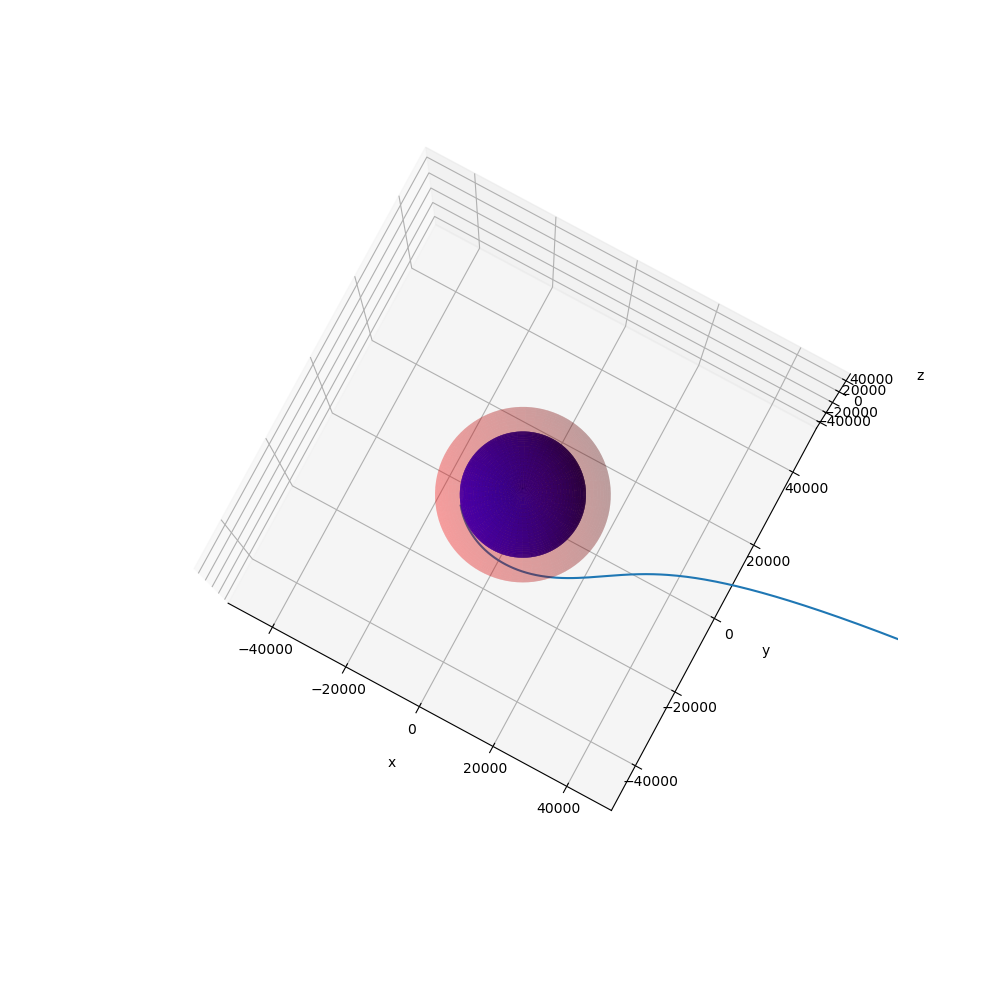

In [86]:
Theta = sol.y[4,:]
Phi = sol.y[6,:]
X = sol.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol.y[0,:] * np.round(np.cos(Theta),14)

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()

outer_horizon = M + np.sqrt(M**2 - (J/M)**2)
inner_horizon = M - np.sqrt(M**2 - (J/M)**2)

ax1.plot3D(X,Y,Z)

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_outer = outer_horizon * np.outer(np.cos(u), np.sin(v))
y_outer = outer_horizon * np.outer(np.sin(u), np.sin(v))
z_outer = outer_horizon * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

ax1.plot_surface(x_outer,y_outer,z_outer, color = 'b')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.2)

zoom = 10

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()

In [94]:
print(outer_horizon)

14358.898943540673


In [95]:
r_stop = 16000

def event_function(t,r):
    R = r[0]
    return R-r_stop

event_function.terminal = True

sol2 = solve_ivp(system_of_odes, t_span, initial_conditions, method='DOP853', t_eval = t_eval, events=event_function, dense_output=True, rtol = 1e-8, atol = 1e-10)

print(sol2.t_events)
print(sol2.y_events)

[array([3931773.14898111])]
[array([[ 1.60000000e+04, -3.08541481e+00, -4.17783087e+06,
         9.79831532e-01,  1.57079633e+00, -3.14921305e-12,
        -1.42648211e+00]])]


In [96]:
sol2y = sol2.y_events
r01 = np.array([sol2y]) #R(0),pR(0),t(0),pt(0),theta(0),ptheta(0),phi(0)
#print(sol2y)
#print(sol2y[0][0])
#print(r01)
#print(initial_conditions)

ti_2 = sol2.t_events[0][0]
tf_2 = (3e8)/6
t_span2 = (ti_2, tf_2)
t_eval2 = np.linspace(ti_2,tf_2,300000)

sol_part1 = solve_ivp(system_of_odes, t_span2, sol2y[0][0], method='DOP853', t_eval = t_eval2, dense_output=True, rtol = 1e-8, atol = 1e-10)

print(sol_part1)

  message: 'Required step size is less than spacing between numbers.'
     nfev: 3113
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000014C51DCB9A0>
   status: -1
  success: False
        t: array([3931773.14898111, 3931926.71024915, 3932080.27151719,
       3932233.83278524, 3932387.39405328, 3932540.95532132,
       3932694.51658936, 3932848.0778574 , 3933001.63912544,
       3933155.20039348, 3933308.76166152, 3933462.32292956,
       3933615.8841976 , 3933769.44546564, 3933923.00673369,
       3934076.56800173, 3934230.12926977, 3934383.69053781,
       3934537.25180585, 3934690.81307389, 3934844.37434193,
       3934997.93560997, 3935151.49687801, 3935305.05814605,
       3935458.6194141 , 3935612.18068214, 3935765.74195018,
       3935919.30321822, 3936072.86448626, 3936226.4257543 ,
       3936379.98702234, 3936533.54829038, 3936687.10955842,
       3936840.67082646, 3936994.2320945 , 3937147.79336255,
       3937301.35463059, 3937454

<IPython.core.display.Javascript object>


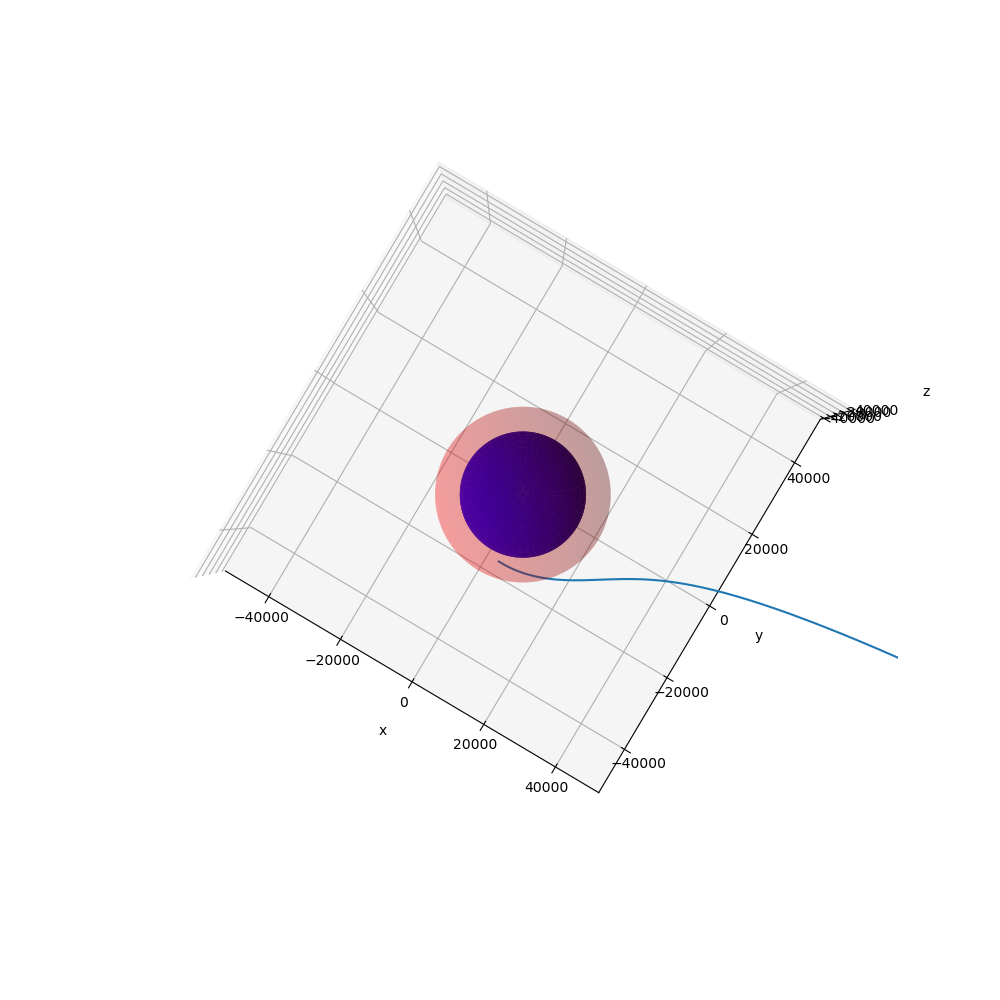

In [97]:
Theta = sol2.y[4,:]
Phi = sol2.y[6,:]
X = sol2.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol2.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol2.y[0,:] * np.round(np.cos(Theta),14)

#Theta = sol_part1.y[4,:]
#Phi = sol_part1.y[6,:]
#X = sol_part1.y[0,:] * np.sin(Theta) * np.cos(Phi)
#Y = sol_part1.y[0,:] * np.sin(Theta) * np.sin(Phi)
#Z = sol_part1.y[0,:] * np.round(np.cos(Theta),14)

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()

ax1.plot3D(X,Y,Z)

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_outer = outer_horizon * np.outer(np.cos(u), np.sin(v))
y_outer = outer_horizon * np.outer(np.sin(u), np.sin(v))
z_outer = outer_horizon * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

ax1.plot_surface(x_outer,y_outer,z_outer, color = 'b')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.2)

zoom = 10

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()
plt.show()

In [101]:
print(sol2y[0][0])

[ 1.60000000e+04 -3.08541481e+00 -4.17783087e+06  9.79831532e-01
  1.57079633e+00 -3.14921305e-12 -1.42648211e+00]


In [107]:
particle1_ic = np.array([sol2y[0][0][0],sol2y[0][0][1]+(1/2)*sol2y[0][0][1], sol2y[0][0][2], sol2y[0][0][3], sol2y[0][0][4], sol2y[0][0][5]+(1/2)*sol2y[0][0][5], sol2y[0][0][6]])
particle2_ic = np.array([sol2y[0][0][0],sol2y[0][0][1]-(1/2)*sol2y[0][0][1], sol2y[0][0][2], sol2y[0][0][3], sol2y[0][0][4], sol2y[0][0][5]-(1/2)*sol2y[0][0][5], sol2y[0][0][6]])
print(particle1_ic)
print(particle2_ic)

#R(0),pR(0),t(0),pt(0),theta(0),ptheta(0),phi(0)

[ 1.60000000e+04 -4.62812222e+00 -4.17783087e+06  9.79831532e-01
  1.57079633e+00 -4.72381958e-12 -1.42648211e+00]
[ 1.60000000e+04 -1.54270741e+00 -4.17783087e+06  9.79831532e-01
  1.57079633e+00 -1.57460653e-12 -1.42648211e+00]


In [109]:
sol_particle1 = solve_ivp(system_of_odes, t_span2, particle1_ic, method='DOP853', t_eval = t_eval2, dense_output=True, rtol = 1e-8, atol = 1e-10)
sol_particle2 = solve_ivp(system_of_odes, t_span2, particle2_ic, method='DOP853', t_eval = t_eval2, dense_output=True, rtol = 1e-8, atol = 1e-10)
print('Solutions Complete')

Solutions Complete


TypeError: only integer scalar arrays can be converted to a scalar index

<IPython.core.display.Javascript object>


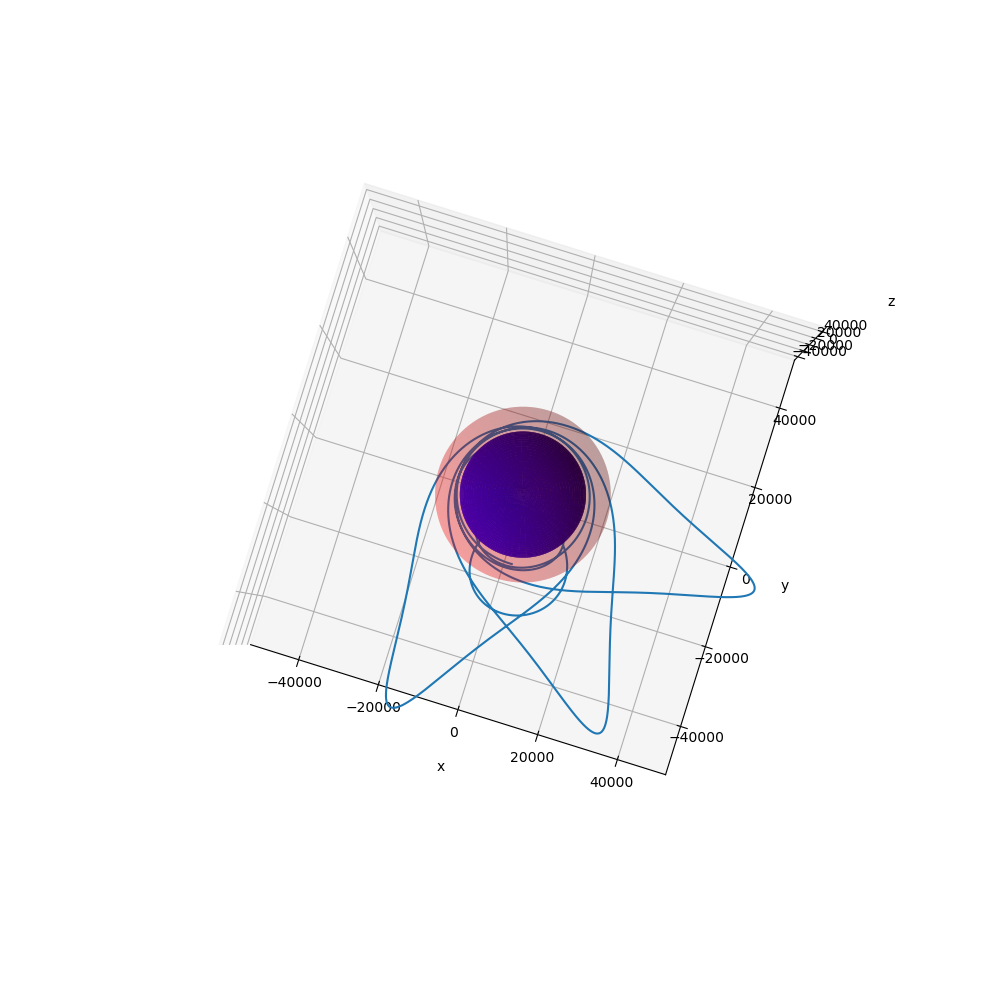

In [122]:
Theta = sol2.y[4,:]
Phi = sol2.y[6,:]

Theta1 = sol_particle1.y[4,:]
Phi1 = sol_particle1.y[6,:]

Theta2 = sol_particle2.y[4,:]
Phi2 = sol_particle2.y[6,:]

#All solutions on one plot
#X = np.concatenate([sol2.y[0,:] * np.sin(Theta) * np.cos(Phi),sol_particle1.y[0,:] * np.sin(Theta1) * np.cos(Phi1),sol_particle2.y[0,:] * np.sin(Theta2) * np.cos(Phi2)])
#Y = np.concatenate([sol2.y[0,:] * np.sin(Theta) * np.sin(Phi), sol_particle1.y[0,:] * np.sin(Theta1) * np.sin(Phi1), sol_particle2.y[0,:] * np.sin(Theta2) * np.sin(Phi2)])
#Z = np.concatenate([sol2.y[0,:] * np.round(np.cos(Theta),14),sol_particle1.y[0,:] * np.round(np.cos(Theta1),14),sol_particle2.y[0,:] * np.round(np.cos(Theta2),14)])

#Individual Solutions
'''
Theta = sol2.y[4,:]
Phi = sol2.y[6,:]
X = sol2.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol2.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol2.y[0,:] * np.round(np.cos(Theta),14)
'''

'''
Theta = sol_particle1.y[4,:]
Phi = sol_particle1.y[6,:]
X = sol_particle1.y[0,:] * np.sin(Theta1) * np.cos(Phi1)
Y = sol_particle1.y[0,:] * np.sin(Theta1) * np.sin(Phi1)
Z = sol_particle1.y[0,:] * np.round(np.cos(Theta1),14)
'''

#'''
Theta = sol_particle2.y[4,:]
Phi = sol_particle2.y[6,:]
X = sol_particle2.y[0,:] * np.sin(Theta2) * np.cos(Phi2)
Y = sol_particle2.y[0,:] * np.sin(Theta2) * np.sin(Phi2)
Z = sol_particle2.y[0,:] * np.round(np.cos(Theta2),14)
#'''

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()

ax1.plot3D(X,Y,Z)

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_outer = outer_horizon * np.outer(np.cos(u), np.sin(v))
y_outer = outer_horizon * np.outer(np.sin(u), np.sin(v))
z_outer = outer_horizon * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

ax1.plot_surface(x_outer,y_outer,z_outer, color = 'b')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.2)

zoom = 10

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()
plt.show()

[1.57079633 1.57079633 1.57079633 ... 1.57079633 1.57079633 1.57079633]
